In [1]:
#导入包以及设置随机种子
%pip install -r requirements.txt
import numpy as np
import torchvision as tv
import torch as t
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import random
seed = 42
t.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
t.cuda.manual_seed_all(seed)
t.backends.cudnn.deterministic = True
t.backends.cudnn.benchmark = False

In [2]:
#定义超参数类
class argparse():
    pass

args = argparse()
args.epochs, args.learning_rate, args.patience = [30, 0.001, 4]
args.batch_size = 16
args.save_path = 'model/'
args.device, = [t.device("cuda:{}".format(0) if t.cuda.is_available() else "cpu"),]

In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    """
    注意：原论文中，在虚线残差结构的主分支上，第一个1x1卷积层的步距是2，第二个3x3卷积层步距是1。
    但在pytorch官方实现过程中是第一个1x1卷积层的步距是1，第二个3x3卷积层步距是2，
    这么做的好处是能够在top1上提升大概0.5%的准确率。
    可参考Resnet v1.5 https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch
    """
    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1, downsample=None,
                 groups=1, width_per_group=64):
        super(Bottleneck, self).__init__()

        width = int(out_channel * (width_per_group / 64.)) * groups

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=width,
                               kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, groups=groups,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=width, out_channels=out_channel*self.expansion,
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 blocks_num,
                 num_classes=1000,
                 include_top=True,
                 groups=1,
                 width_per_group=64):
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64

        self.groups = groups
        self.width_per_group = width_per_group

        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel,
                            channel,
                            downsample=downsample,
                            stride=stride,
                            groups=self.groups,
                            width_per_group=self.width_per_group))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel,
                                channel,
                                groups=self.groups,
                                width_per_group=self.width_per_group))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)
            x = t.flatten(x, 1)
            x = self.fc(x)

        return x


def resnet34(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet34-333f7ec4.pth
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet50(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet50-19c8e357.pth
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet101(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top)


def resnext50_32x4d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth
    groups = 32
    width_per_group = 4
    return ResNet(Bottleneck, [3, 4, 6, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)


def resnext101_32x8d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth
    groups = 32
    width_per_group = 8
    return ResNet(Bottleneck, [3, 4, 23, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)
net = resnet34(10).to(args.device)

In [4]:
#定义早停类
class EarlyStopping():
    def __init__(self,patience=7,verbose=False,delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
    def __call__(self,val_loss,model,path):
        print("val_loss={}".format(val_loss))
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss,model,path)
        elif score < self.best_score+self.delta:
            self.counter+=1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter>=self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss,model,path)
            self.counter = 0
    def save_checkpoint(self,val_loss,model,path):
        if self.verbose:
            print(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        t.save(model.state_dict(), path+'/'+'model_checkpoint.pth')
        self.val_loss_min = val_loss

In [5]:
#加载数据集Dataset,DataLoader
# 定义对数据的预处理
transform = transforms.Compose([
        transforms.ToTensor(), # 转为Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 归一化
                             ])



trainset = tv.datasets.ImageFolder(root='./data/cifar/train',transform=transform)

trainloader = t.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                          shuffle=True, num_workers=2)

testset = tv.datasets.ImageFolder(root='./data/cifar/test',  transform=transform)

testloader = t.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
#设置loss，优化器等
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = optim.Adam(net.parameters(), lr=args.learning_rate) # 优化器
early_stopping = EarlyStopping(patience=args.patience,verbose=True)

In [6]:
#训练模型
def train_model(model, batch_size, patience, n_epochs):
    avg_train_losses = []
    avg_valid_losses = []
    train_losses = []
    valid_losses = []
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # 训练模式
        for batch, (data, target) in enumerate(trainloader, 1):
            # 把数据存到GPU上
            data = data.to(args.device)
            target = target.to(args.device)
            # 梯度清零
            optimizer.zero_grad()
            # 前向传播
            output = model(data)
            # 计算loss
            loss = criterion(output, target)
            # 反向传播
            loss.backward()
            # 更新参数
            optimizer.step()
            # 记录训练loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # 切换到验证模式
        for data, target in testloader:
            # 把数据存到GPU上
            data = data.to(args.device)
            target = target.to(args.device)
            # 前向传播
            output = model(data)
            # 计算loss
            loss = criterion(output, target)
            # 记录验证loss
            valid_losses.append(loss.item())

        # 计算平均loss
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # 下个epoch前清空loss
        train_losses = []
        valid_losses = []
        #==================early stopping======================
        early_stopping(avg_valid_losses[-1],model=model,path='model')
        if early_stopping.early_stop:
            print("Early stopping")
            break
        #====================adjust lr========================
        lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    return  model, avg_train_losses, avg_valid_losses
    

In [8]:
# baseline训练 使用了batchnorm，learningrate_decay,earlystopping
model, train_losses, valid_losses = train_model(net, args.batch_size, args.patience, args.epochs)

[ 1/30] train_loss: 2.00228 valid_loss: 1.87363
val_loss=1.8736258753776551
Validation loss decreased (inf --> 1.873626).  Saving model ...
[ 2/30] train_loss: 1.71378 valid_loss: 1.62153
val_loss=1.6215307261943817
Validation loss decreased (1.873626 --> 1.621531).  Saving model ...
Updating learning rate to 5e-05
[ 3/30] train_loss: 1.37990 valid_loss: 1.31292
val_loss=1.3129229586601256
Validation loss decreased (1.621531 --> 1.312923).  Saving model ...
[ 4/30] train_loss: 1.27232 valid_loss: 1.26039
val_loss=1.2603876221179962
Validation loss decreased (1.312923 --> 1.260388).  Saving model ...
Updating learning rate to 1e-05
[ 5/30] train_loss: 1.17021 valid_loss: 1.23929
val_loss=1.2392868629932403
Validation loss decreased (1.260388 --> 1.239287).  Saving model ...
[ 6/30] train_loss: 1.16020 valid_loss: 1.23648
val_loss=1.2364766626358032
Validation loss decreased (1.239287 --> 1.236477).  Saving model ...
Updating learning rate to 5e-06
[ 7/30] train_loss: 1.12742 valid_loss:

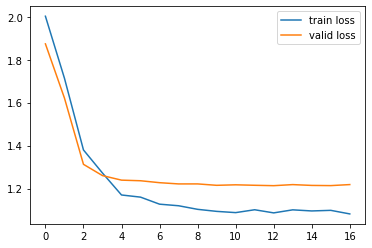

In [9]:
#训练可视化
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.legend()
plt.show()


In [7]:
def get_accuracy():
    correct = 0 # 预测正确的图片数
    total = 0 # 总共的图片数


    # 由于测试的时候不需要求导，可以暂时关闭autograd，提高速度，节约内存
    with t.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(args.device)
            labels = labels.to(args.device)
            outputs = net(images)
            _, predicted = t.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()

    print('10000张测试集中的准确率为: %d %%' % (100 * correct / total))

In [11]:
# baseline测试
get_accuracy()

10000张测试集中的准确率为: 45%


In [7]:
#加载数据集Dataset,DataLoader
# 定义对数据的预处理
transform = transforms.Compose([
        transforms.ToTensor(), # 转为Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 归一化
                             ])
transform_train = transforms.Compose([
         # 对原始32*32图像四周各填充4个0像素（40*40），然后随机裁剪成32*32
         transforms.RandomCrop(32, padding=4),
 
         # 按0.5的概率水平翻转图片
         transforms.RandomHorizontalFlip(),
 
         transforms.ToTensor(),
         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


trainset = tv.datasets.ImageFolder(root='./data/cifar/train',transform=transform_train)

trainloader = t.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                          shuffle=True, num_workers=2)

testset = tv.datasets.ImageFolder(root='./data/cifar/test',  transform=transform)

testloader = t.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                         shuffle=False, num_workers=2)



# 对图片random crop&flip
model, train_losses, valid_losses = train_model(net, args.batch_size, args.patience, args.epochs)

[ 1/30] train_loss: 2.08010 valid_loss: 2.22998
val_loss=2.229979174232483
Validation loss decreased (inf --> 2.229979).  Saving model ...
[ 2/30] train_loss: 1.92616 valid_loss: 2.12214
val_loss=2.1221358406066892
Validation loss decreased (2.229979 --> 2.122136).  Saving model ...
Updating learning rate to 5e-05
[ 3/30] train_loss: 1.80495 valid_loss: 1.61325
val_loss=1.613250291442871
Validation loss decreased (2.122136 --> 1.613250).  Saving model ...
[ 4/30] train_loss: 1.67074 valid_loss: 1.53172
val_loss=1.531720094013214
Validation loss decreased (1.613250 --> 1.531720).  Saving model ...
Updating learning rate to 1e-05
[ 5/30] train_loss: 1.61074 valid_loss: 1.48498
val_loss=1.4849812232017516
Validation loss decreased (1.531720 --> 1.484981).  Saving model ...
[ 6/30] train_loss: 1.60771 valid_loss: 1.46946
val_loss=1.4694588244438171
Validation loss decreased (1.484981 --> 1.469459).  Saving model ...
Updating learning rate to 5e-06
[ 7/30] train_loss: 1.57967 valid_loss: 1.

In [8]:
# random crop&flip
get_accuracy()

10000张测试集中的准确率为: 46 %


In [13]:
#加载数据集Dataset,DataLoader
# 定义对数据的预处理
import PIL.Image as Image
class Cutout(object):
     def __init__(self, hole_size):
         # 正方形马赛克的边长，像素为单位
         self.hole_size = hole_size
 
     def __call__(self, img):
         return cutout(img, self.hole_size)
 
def cutout(img, hole_size):
     y = np.random.randint(32)
     x = np.random.randint(32)
 
     half_size = hole_size // 2
 
     x1 = np.clip(x - half_size, 0, 32)
     x2 = np.clip(x + half_size, 0, 32)
     y1 = np.clip(y - half_size, 0, 32)
     y2 = np.clip(y + half_size, 0, 32)
 
     imgnp = np.array(img)
 
     imgnp[y1:y2, x1:x2] = 0
     img = Image.fromarray(imgnp.astype('uint8')).convert('RGB')
     return img

transform_train = transforms.Compose([
         # 对原始32*32图像四周各填充4个0像素（40*40），然后随机裁剪成32*32
         transforms.RandomCrop(32, padding=4),
 
         # 随机马赛克，大小为6*6
         Cutout(6),
 
         # 按0.5的概率水平翻转图片
         transforms.RandomHorizontalFlip(),
 
         transforms.ToTensor(),
         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


trainset = tv.datasets.ImageFolder(root='./data/cifar/train',transform=transform_train)

trainloader = t.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                          shuffle=True, num_workers=2)


# cutout
model, train_losses, valid_losses = train_model(net, args.batch_size, args.patience, args.epochs)

[ 1/30] train_loss: 1.95683 valid_loss: 2.36525
val_loss=2.3652473142147064
Validation loss decreased (inf --> 2.365247).  Saving model ...
[ 2/30] train_loss: 1.85759 valid_loss: 1.61252
val_loss=1.612519322013855
Validation loss decreased (2.365247 --> 1.612519).  Saving model ...
Updating learning rate to 5e-05
[ 3/30] train_loss: 1.62085 valid_loss: 1.47012
val_loss=1.4701238010406494
Validation loss decreased (1.612519 --> 1.470124).  Saving model ...
[ 4/30] train_loss: 1.56600 valid_loss: 1.45538
val_loss=1.4553839234352113
Validation loss decreased (1.470124 --> 1.455384).  Saving model ...
Updating learning rate to 1e-05
[ 5/30] train_loss: 1.54659 valid_loss: 1.41573
val_loss=1.415728151988983
Validation loss decreased (1.455384 --> 1.415728).  Saving model ...
[ 6/30] train_loss: 1.52637 valid_loss: 1.41449
val_loss=1.4144929316520691
Validation loss decreased (1.415728 --> 1.414493).  Saving model ...
Updating learning rate to 5e-06
[ 7/30] train_loss: 1.51902 valid_loss: 1

In [14]:
# cutout
get_accuracy()

10000张测试集中的准确率为: 47 %


In [8]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = t.randperm(batch_size).cuda()
    else:
        index = t.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

#训练模型
def train_model(model, batch_size, patience, n_epochs):
    avg_train_losses = []
    avg_valid_losses = []
    train_losses = []
    valid_losses = []
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # 训练模式
        for batch, (data, target) in enumerate(trainloader, 1):
            # 把数据存到GPU上
            data = data.to(args.device)
            target = target.to(args.device)
            data, targets_a, targets_b, lam = mixup_data(data, target,
                                                   1.)
            # 梯度清零
            optimizer.zero_grad()
            # 前向传播
            output = model(data)
            # 计算loss
            loss = mixup_criterion(criterion, output, targets_a, targets_b, lam)
            # 反向传播
            loss.backward()
            # 更新参数
            optimizer.step()
            # 记录训练loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # 切换到验证模式
        for data, target in testloader:
            # 把数据存到GPU上
            data = data.to(args.device)
            target = target.to(args.device)
            data, targets_a, targets_b, lam = mixup_data(data, target,
                                                   1.)
            # 前向传播
            output = model(data)
            # 计算loss
            loss = mixup_criterion(criterion, output, targets_a, targets_b, lam)
            # 记录验证loss
            valid_losses.append(loss.item())

        # 计算平均loss
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # 下个epoch前清空loss
        train_losses = []
        valid_losses = []
        #==================early stopping======================
        early_stopping(avg_valid_losses[-1],model=model,path='model')
        if early_stopping.early_stop:
            print("Early stopping")
            break
        #====================adjust lr========================
        lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    return  model, avg_train_losses, avg_valid_losses

# mixup
model, train_losses, valid_losses = train_model(net, args.batch_size, args.patience, args.epochs)


[ 1/30] train_loss: 2.21654 valid_loss: 3.03949
val_loss=3.0394861227989196
Validation loss decreased (inf --> 3.039486).  Saving model ...
[ 2/30] train_loss: 2.08533 valid_loss: 1.91787
val_loss=1.9178737157821655
Validation loss decreased (3.039486 --> 1.917874).  Saving model ...
Updating learning rate to 5e-05
[ 3/30] train_loss: 1.86720 valid_loss: 1.46836
val_loss=1.4683603600502013
Validation loss decreased (1.917874 --> 1.468360).  Saving model ...
[ 4/30] train_loss: 1.81452 valid_loss: 1.38494
val_loss=1.3849391384124756
Validation loss decreased (1.468360 --> 1.384939).  Saving model ...
Updating learning rate to 1e-05
[ 5/30] train_loss: 1.77805 valid_loss: 1.35308
val_loss=1.3530834151268005
Validation loss decreased (1.384939 --> 1.353083).  Saving model ...
[ 6/30] train_loss: 1.76704 valid_loss: 1.36777
val_loss=1.3677742599487304
EarlyStopping counter: 1 out of 4
Updating learning rate to 5e-06
[ 7/30] train_loss: 1.76533 valid_loss: 1.35803
val_loss=1.358031424999237

In [9]:
# mixup
get_accuracy()

10000张测试集中的准确率为: 49 %


In [8]:
def shuffle_minibatch(x, y):
    assert x.size(0)== y.size(0)
    indices = t.randperm(x.size(0))
    return x[indices], y[indices]
#训练模型
def train_model(model, batch_size, patience, n_epochs):
    avg_train_losses = []
    avg_valid_losses = []
    train_losses = []
    valid_losses = []
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # 训练模式
        for batch, (data, target) in enumerate(trainloader, 1):
            # 把数据存到GPU上
            data = data.to(args.device)
            target = target.to(args.device)
            cutmix_decision = np.random.rand()
            if cutmix_decision > 0.50:
                # Cutmix: https://arxiv.org/pdf/1905.04899.pdf
                x_train_shuffled, y_train_shuffled = shuffle_minibatch(data, target)
                lam = np.random.beta(1, 1)
                cut_rat = np.sqrt(1. - lam)
                cut_w = np.int64(32 * cut_rat)
                cut_h = np.int64(32 * cut_rat)

                # uniform
                cx = np.random.randint(32)
                cy = np.random.randint(32)

                bbx1 = np.clip(cx - cut_w // 2, 0, 32)
                bby1 = np.clip(cy - cut_h // 2, 0, 32)
                bbx2 = np.clip(cx + cut_w // 2, 0, 32)
                bby2 = np.clip(cy + cut_h // 2, 0, 32)

                data[:, :, bbx1:bbx2, bby1:bby2] = x_train_shuffled[:, :, bbx1:bbx2, bby1:bby2]
                lam = 1 - (bbx2 - bbx1) * (bby2 - bby1) / (32 * 32)
        
            # Forward pass
            y_preds = model(data)
            
            # Calculate loss
            if cutmix_decision > 0.50:
                loss = criterion(y_preds, target) * lam + criterion(y_preds, y_train_shuffled) * (1. - lam)
            else:
                loss = criterion(y_preds, target)
            
            
            # Backpropagate
            optimizer.zero_grad()  
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # 切换到验证模式
        for data, target in testloader:
            # 把数据存到GPU上
            data = data.to(args.device)
            target = target.to(args.device)
            # 前向传播
            output = model(data)
            # 计算loss
            loss = criterion(output, target)
            # 记录验证loss
            valid_losses.append(loss.item())

        # 计算平均loss
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # 下个epoch前清空loss
        train_losses = []
        valid_losses = []
        #==================early stopping======================
        early_stopping(avg_valid_losses[-1],model=model,path='model')
        if early_stopping.early_stop:
            print("Early stopping")
            break
        #====================adjust lr========================
        lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    return  model, avg_train_losses, avg_valid_losses


# cutmix
model, train_losses, valid_losses = train_model(net, args.batch_size, args.patience, args.epochs)

[ 1/30] train_loss: 2.06623 valid_loss: 2.23897
val_loss=2.2389658091545104
Validation loss decreased (inf --> 2.238966).  Saving model ...
[ 2/30] train_loss: 1.91958 valid_loss: 1.87121
val_loss=1.87121098279953
Validation loss decreased (2.238966 --> 1.871211).  Saving model ...
Updating learning rate to 5e-05
[ 3/30] train_loss: 1.75061 valid_loss: 1.42077
val_loss=1.4207736505508424
Validation loss decreased (1.871211 --> 1.420774).  Saving model ...
[ 4/30] train_loss: 1.67514 valid_loss: 1.34185
val_loss=1.34185367269516
Validation loss decreased (1.420774 --> 1.341854).  Saving model ...
Updating learning rate to 1e-05
[ 5/30] train_loss: 1.62610 valid_loss: 1.32748
val_loss=1.3274779858589172
Validation loss decreased (1.341854 --> 1.327478).  Saving model ...
[ 6/30] train_loss: 1.59506 valid_loss: 1.30771
val_loss=1.307708592605591
Validation loss decreased (1.327478 --> 1.307709).  Saving model ...
Updating learning rate to 5e-06
[ 7/30] train_loss: 1.57056 valid_loss: 1.30

In [10]:
# cutmix
get_accuracy()

10000张测试集中的准确率为: 53 %


In [9]:
from torchvision import models
class GroupNorm_32(t.nn.GroupNorm):
    def __init__(self, num_channels, num_groups=32, **kwargs):
        super().__init__(num_groups, num_channels, **kwargs)
resnet34_gn = models.resnet34(norm_layer=GroupNorm_32, num_classes=10)
from pytorch_lightning import LightningModule, Trainer
class Model(LightningModule):
    def __init__(self, base):
        super().__init__()
        self.base = base

    def forward(self, x):
        return self.base(x)

    def configure_optimizers(self):
        return t.optim.Adam(self.parameters(), lr=1e-3)

    def step(self, batch):
        x, y  = batch
        y_hat = self(x)
        loss  = nn.CrossEntropyLoss()(y_hat, y)
        return loss, y, y_hat

    def training_step(self, batch, batch_nb):
        loss, _, _ = self.step(batch)
        return {'loss': loss}

    def validation_step(self, batch, batch_nb):
        loss, y, y_hat = self.step(batch)
        return {'loss': loss, 'y': y.detach(), 'y_hat': y_hat.detach()}

    def validation_epoch_end(self, outputs):
        avg_loss = t.stack([x['loss'] for x in outputs]).mean()
        acc = self.get_accuracy(outputs)
        print(f"Epoch:{self.current_epoch} | Loss:{avg_loss} | Accuracy:{acc}")
        return {'loss': avg_loss}
    
    def get_accuracy(self, outputs):
        from sklearn.metrics import accuracy_score
        y = t.cat([x['y'] for x in outputs])
        y_hat = t.cat([x['y_hat'] for x in outputs])
        preds = y_hat.argmax(1)
        return accuracy_score(y.cpu().numpy(), preds.cpu().numpy())
model_gn = Model(resnet34_gn).to(args.device)
debug = False
trainer = Trainer(gpus=1, max_epochs=30, 
                  num_sanity_val_steps=1 if debug else 0)


# 将resnet34_bn模型转换为resnet34_gn模型
trainer.fit(model_gn,trainloader,testloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | base | ResNet | 21.3 M
--------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.159    Total estimated model params size (MB)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many 

Epoch 29: 100%|██████████| 1250/1250 [00:41<00:00, 30.01it/s, loss=0.116, v_num=3]


In [11]:
t.save(model_gn, 'resnet34_gn.pth')

In [12]:
#训练模型
def train_model(model, batch_size, patience, n_epochs):
    avg_train_losses = []
    avg_valid_losses = []
    train_losses = []
    valid_losses = []
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # 训练模式
        for batch, (data, target) in enumerate(trainloader, 1):
            # 把数据存到GPU上
            data = data.to(args.device)
            target = target.to(args.device)
            # 梯度清零
            optimizer.zero_grad()
            # 前向传播
            output = model(data)
            # 计算loss
            loss = criterion(output, target)
            # 反向传播
            loss.backward()
            # 梯度裁剪
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # 更新参数
            optimizer.step()
            # 记录训练loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # 切换到验证模式
        for data, target in testloader:
            # 把数据存到GPU上
            data = data.to(args.device)
            target = target.to(args.device)
            # 前向传播
            output = model(data)
            # 计算loss
            loss = criterion(output, target)
            # 记录验证loss
            valid_losses.append(loss.item())

        # 计算平均loss
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # 下个epoch前清空loss
        train_losses = []
        valid_losses = []
        #==================early stopping======================
        early_stopping(avg_valid_losses[-1],model=model,path='model')
        if early_stopping.early_stop:
            print("Early stopping")
            break
        #====================adjust lr========================
        lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    return  model, avg_train_losses, avg_valid_losses

# 梯度裁剪
model, train_losses, valid_losses = train_model(net, args.batch_size, args.patience, args.epochs)

[ 1/30] train_loss: 2.16646 valid_loss: 1.93164
val_loss=1.9316405723571777
Validation loss decreased (inf --> 1.931641).  Saving model ...
[ 2/30] train_loss: 1.89352 valid_loss: 1.96421
val_loss=1.9642088680267333
EarlyStopping counter: 1 out of 4
Updating learning rate to 5e-05
[ 3/30] train_loss: 1.59027 valid_loss: 1.49895
val_loss=1.4989541625022889
Validation loss decreased (1.931641 --> 1.498954).  Saving model ...
[ 4/30] train_loss: 1.50472 valid_loss: 1.45122
val_loss=1.4512166882514954
Validation loss decreased (1.498954 --> 1.451217).  Saving model ...
Updating learning rate to 1e-05
[ 5/30] train_loss: 1.46673 valid_loss: 1.45484
val_loss=1.4548353902816773
EarlyStopping counter: 1 out of 4
[ 6/30] train_loss: 1.45509 valid_loss: 1.49617
val_loss=1.4961650044441224
EarlyStopping counter: 2 out of 4
Updating learning rate to 5e-06
[ 7/30] train_loss: 1.43581 valid_loss: 1.50623
val_loss=1.5062320848464965
EarlyStopping counter: 3 out of 4
[ 8/30] train_loss: 1.44837 valid_

In [15]:
# 梯度裁剪
get_accuracy()

10000张测试集中的准确率为: 47 %


In [8]:
def l2_penalty(w):
    return t.sum(w.pow(2)) / 2
#训练模型
optimizer = optim.SGD(net.parameters(), lr=args.learning_rate, momentum=0.9, weight_decay=5e-4) #优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）
def train_model(model, batch_size, patience, n_epochs):
    avg_train_losses = []
    avg_valid_losses = []
    train_losses = []
    valid_losses = []
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # 训练模式
        for batch, (data, target) in enumerate(trainloader, 1):
            # 把数据存到GPU上
            data = data.to(args.device)
            target = target.to(args.device)
            # 梯度清零
            optimizer.zero_grad()
            # 前向传播
            output = model(data)
            # 计算loss
            loss = criterion(output, target)
            # 反向传播
            loss.backward()
            # 更新参数
            optimizer.step()
            # 记录训练loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # 切换到验证模式
        for data, target in testloader:
            # 把数据存到GPU上
            data = data.to(args.device)
            target = target.to(args.device)
            # 前向传播
            output = model(data)
            # 计算loss
            loss = criterion(output, target)
            # 记录验证loss
            valid_losses.append(loss.item())

        # 计算平均loss
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # 下个epoch前清空loss
        train_losses = []
        valid_losses = []
        #==================early stopping======================
        early_stopping(avg_valid_losses[-1],model=model,path='model')
        if early_stopping.early_stop:
            print("Early stopping")
            break
        #====================adjust lr========================
        lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    return  model, avg_train_losses, avg_valid_losses


# 权重衰减
model, train_losses, valid_losses = train_model(net, args.batch_size, args.patience, args.epochs)

[ 1/30] train_loss: 2.10855 valid_loss: 1.88664
val_loss=1.8866373000144958
Validation loss decreased (inf --> 1.886637).  Saving model ...
[ 2/30] train_loss: 1.74421 valid_loss: 1.58326
val_loss=1.5832586451530457
Validation loss decreased (1.886637 --> 1.583259).  Saving model ...
Updating learning rate to 5e-05
[ 3/30] train_loss: 1.41282 valid_loss: 1.45728
val_loss=1.4572807833194732
Validation loss decreased (1.583259 --> 1.457281).  Saving model ...
[ 4/30] train_loss: 1.34946 valid_loss: 1.42323
val_loss=1.423228444480896
Validation loss decreased (1.457281 --> 1.423228).  Saving model ...
Updating learning rate to 1e-05
[ 5/30] train_loss: 1.28969 valid_loss: 1.42697
val_loss=1.4269720645427704
EarlyStopping counter: 1 out of 4
[ 6/30] train_loss: 1.30480 valid_loss: 1.41963
val_loss=1.4196281918525695
Validation loss decreased (1.423228 --> 1.419628).  Saving model ...
Updating learning rate to 5e-06
[ 7/30] train_loss: 1.28283 valid_loss: 1.41378
val_loss=1.4137841077327729

In [11]:
# 权重衰减
get_accuracy()

10000张测试集中的准确率为: 48 %


In [9]:
transform = transforms.Compose([
        transforms.ToTensor(), # 转为Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 归一化
                             ])
transform_train = transforms.Compose([
         # 对原始32*32图像四周各填充4个0像素（40*40），然后随机裁剪成32*32
         transforms.RandomCrop(32, padding=4),
 
         # 按0.5的概率水平翻转图片
         transforms.RandomHorizontalFlip(),
 
         transforms.ToTensor(),
         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


trainset = tv.datasets.ImageFolder(root='./data/cifar/train',transform=transform_train)

trainloader = t.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                          shuffle=True, num_workers=2)

testset = tv.datasets.ImageFolder(root='./data/cifar/test',  transform=transform)

testloader = t.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                         shuffle=False, num_workers=2)

print(trainset)
    

Dataset ImageFolder
    Number of datapoints: 7527
    Root location: ./data/cifar/train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


In [21]:
# 类别不均衡问题下Baseline
model, train_losses, valid_losses = train_model(net, args.batch_size, args.patience, args.epochs)

[ 1/30] train_loss: 2.10590 valid_loss: 2.17729
val_loss=2.177291615486145
Validation loss decreased (inf --> 2.177292).  Saving model ...
[ 2/30] train_loss: 1.93789 valid_loss: 2.40523
val_loss=2.4052278933525084
EarlyStopping counter: 1 out of 4
Updating learning rate to 5e-05
[ 3/30] train_loss: 1.68928 valid_loss: 1.53824
val_loss=1.5382410376548767
Validation loss decreased (2.177292 --> 1.538241).  Saving model ...
[ 4/30] train_loss: 1.59865 valid_loss: 1.49411
val_loss=1.4941063723564147
Validation loss decreased (1.538241 --> 1.494106).  Saving model ...
Updating learning rate to 1e-05
[ 5/30] train_loss: 1.56614 valid_loss: 1.44868
val_loss=1.4486836185455323
Validation loss decreased (1.494106 --> 1.448684).  Saving model ...
[ 6/30] train_loss: 1.55138 valid_loss: 1.45089
val_loss=1.4508922484397888
EarlyStopping counter: 1 out of 4
Updating learning rate to 5e-06
[ 7/30] train_loss: 1.52034 valid_loss: 1.44684
val_loss=1.4468447987556456
Validation loss decreased (1.44868

In [25]:
# 类别不均衡
get_accuracy()

10000张测试集中的准确率为: 26 %


In [10]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight             
import torch 
trainset = tv.datasets.ImageFolder(root='./data/cifar/train',transform=transform_train)                                                           
                                                                                
# For unbalanced dataset we create a weighted sampler                       
weights = make_weights_for_balanced_classes(trainset.imgs, len(trainset.classes))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
                                                                                
train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,sampler = sampler, num_workers=2, pin_memory=True)  

In [11]:
# 通过权重随机过采样
model, train_losses, valid_losses = train_model(net, args.batch_size, args.patience, args.epochs)

[ 1/30] train_loss: 2.10590 valid_loss: 2.17729
val_loss=2.177291615486145
Validation loss decreased (inf --> 2.177292).  Saving model ...
[ 2/30] train_loss: 1.93789 valid_loss: 2.40523
val_loss=2.4052278933525084
EarlyStopping counter: 1 out of 4
Updating learning rate to 5e-05
[ 3/30] train_loss: 1.68928 valid_loss: 1.53824
val_loss=1.5382410376548767
Validation loss decreased (2.177292 --> 1.538241).  Saving model ...
[ 4/30] train_loss: 1.59865 valid_loss: 1.49411
val_loss=1.4941063723564147
Validation loss decreased (1.538241 --> 1.494106).  Saving model ...
Updating learning rate to 1e-05
[ 5/30] train_loss: 1.56614 valid_loss: 1.44868
val_loss=1.4486836185455323
Validation loss decreased (1.494106 --> 1.448684).  Saving model ...
[ 6/30] train_loss: 1.55138 valid_loss: 1.45089
val_loss=1.4508922484397888
EarlyStopping counter: 1 out of 4
Updating learning rate to 5e-06
[ 7/30] train_loss: 1.52034 valid_loss: 1.44684
val_loss=1.4468447987556456
Validation loss decreased (1.44868

In [12]:
# 类别不均衡过采样
get_accuracy()

10000张测试集中的准确率为: 46 %


In [1]:
# 部分标注问题MixMatch
!unzip MixMatch-pytorch-master.zip

Archive:  MixMatch-pytorch-master.zip
   creating: MixMatch-pytorch-master/dataset/
   creating: MixMatch-pytorch-master/dataset/__pycache__/
  inflating: MixMatch-pytorch-master/dataset/__pycache__/cifar10.cpython-37.pyc  
  inflating: MixMatch-pytorch-master/dataset/cifar10.py  
  inflating: MixMatch-pytorch-master/LICENSE  
   creating: MixMatch-pytorch-master/models/
   creating: MixMatch-pytorch-master/models/__pycache__/
  inflating: MixMatch-pytorch-master/models/__pycache__/wideresnet.cpython-37.pyc  
  inflating: MixMatch-pytorch-master/models/wideresnet.py  
  inflating: MixMatch-pytorch-master/README.md  
  inflating: MixMatch-pytorch-master/train.py  
   creating: MixMatch-pytorch-master/utils/
  inflating: MixMatch-pytorch-master/utils/__init__.py  
   creating: MixMatch-pytorch-master/utils/__pycache__/
  inflating: MixMatch-pytorch-master/utils/__pycache__/__init__.cpython-37.pyc  
  inflating: MixMatch-pytorch-master/utils/__pycache__/eval.cpython-37.pyc  
  inflating: 

In [2]:
!python MixMatch-pytorch-master/train.py --gpu 0 --n-labeled 250 --out cifar10@250

==> Preparing cifar10
170499072it [00:59, 2877245.89it/s]                                             
Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
#Labeled: 250 #Unlabeled: 44750 #Val: 5000
==> creating WRN-28-2
    Total params: 1.47M

Epoch: [1 | 1024] LR: 0.002000
Training |################################| (1024/1024) Data: 0.017s | Batch: 0.064s | Total: 0:01:05 | ETA: 0:00:01 | Loss: 1.1968 | Loss_x: 1.1963 | Loss_u: 0.0115 | W: 0.0366
Train Stats |################################| (3/3) Data: 0.006s | Batch: 0.013s | Total: 0:00:00 | ETA: 0:00:01 | Loss: 1.9823 | top1:  35.9375 | top5:  74.4792
Valid Stats |################################| (79/79) Data: 0.001s | Batch: 0.004s | Total: 0:00:00 | ETA: 0:00:01 | Loss: 2.2552 | top1:  20.3600 | top5:  67.4800
Test Stats  |################################| (157/157) Data: 0.001s | Batch: 0.004s | Total: 0:00:00 | ETA: 0:00:01 | Loss: 2.2411 | top1:  2